# The groupby operation (split-apply-combine)
 
The `group by` concept: we want to **apply the same function on subsets of your dataframe, based on some key to split the dataframe in subsets**.

This operation is also referred to as the "split-apply-combine" operation, involving the following steps:
 
* **Splitting** the data into groups based on some criteria
* **Applying** a function to each group independently
* **Combining** the results into a data structure

<img src="../images/splitApplyCombine.png">

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which 
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

Client Scheduler: tcp://127.0.0.1:39935 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 2.00 GB


In [2]:
import dask.dataframe as dd 
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

To illustrate the groupby operation in the image above, let's see how this can be accomplished with Dask in the following steps:

- Create a pandas dataframe 

In [3]:
pdf = pd.DataFrame({'key':['A','B','C','A','B','C','A','B','C'],
                   'data': [0, 5, 10, 5, 10, 15, 10, 15, 20]})
pdf

,key,data
0,A,0
1,B,5
2,C,10
3,A,5
4,B,10
5,C,15
6,A,10
7,B,15
8,C,20


- Create a dask dataframe from the created pandas dataframe 


In [4]:
ddf = dd.from_pandas(pdf, npartitions=5)
ddf

,key,data
npartitions=4,,
0,object,int64
2,...,...
4,...,...
6,...,...
8,...,...


You can see that the dask dataframe is a lazily-evaluated dataframe object. 

## GroupBy Operation

Dask provides a `groupby` method for us to do the **split-apply-combine** operation. 

Using groupby, we will group elements by column **`key`** and compute some aggregations such as `sum`, `mean`, etc..

In [5]:
ddf.groupby(by='key')

## Aggregation 

Once the GroupBy object has been created, several methods are available to perform a computation on the grouped data. 

An obvious one is aggregation via the [`aggregate` or `agg()`](https://dask.pydata.org/en/latest/dataframe-groupby.html#aggregate) method:

In [6]:
ddf.groupby(by='key').aggregate('sum')

,data
npartitions=1,
,int64
,...


Once again, one notices that Dask returns a lazily-evaluated object until we ask it to compute the actual result. 

In [7]:
ddf.groupby(by='key').aggregate('sum').compute()

,data
key,
A,15
B,30
C,45


As you can see, the result of the aggregation will have the group names as the new index along the grouped axis.

The above can also be accomplished without using the `aggregate` method in the following way:

In [8]:
ddf.groupby(by='key').sum().compute()

,data
key,
A,15
B,30
C,45


In [9]:
ddf.groupby(by='key').mean().compute()

,data
key,
A,5.0
B,10.0
C,15.0


Aggregating functions are the ones that reduce the dimension of the returned objects. Some common aggregating functions are tabulated below:

| **Function**  | **Description**               |
|---------------|-------------------------------|
| **`mean()`**  | Compute mean of groups        |
| **`sum()`**   | Compute sum of groups         |
| **`size()`**  | Compute group sizes           |
| **`count()`** | Compute count of group        |
| **`std()`**   | Standard deviation of groups  |
| **`var()`**   | Compute variance of groups    |
| **`first()`** | Compute first of group values |
| **`last()`**  | Compute last of group values  |
| **`min()`**   | Compute min of group values   |
| **`max()`**   | Compute max of group values   |

## Applying multiple functions at once 

With grouped `dask.dataframe` you can also pass a list or dict of functions to do aggregation with, outputting a DataFrame:

In [10]:
grouped = ddf.groupby(by='key')
grouped

In [11]:
grouped.agg(['sum', 'mean', 'std', 'max', 'min']).compute()

data                   
     sum  mean  std max min
key                        
A     15   5.0  5.0  10   0
B     30  10.0  5.0  15   5
C     45  15.0  5.0  20  10

The resulting aggregations are named for the functions themselves. If you need to rename, then you can add in a chained operation like:

In [12]:
grouped.agg(['sum', 'mean', 'std', 'max', 'min'])\
       .rename(columns={'sum': 'foo_sum', 
                        'mean': 'bar_mean'})\
        .compute()

data                      
    foo_sum bar_mean  std max min
key                              
A        15      5.0  5.0  10   0
B        30     10.0  5.0  15   5
C        45     15.0  5.0  20  10

## Transformation 

Pandas provides a `transformation` method for groupby objects. This method returns an object that is indexed the same (same size) as the one being grouped. 

This method is not implemented for Dask groupby objects yet. However, this functionality can be easily achieved with custom implementation. For example, suppose we wished to standardize the data within each group:

In [13]:
index = pd.date_range('10/1/1999', periods=1100)
ts = pd.Series(np.random.normal(0.5, 2, 1100), index)
dts = dd.from_pandas(ts, npartitions=1)
dts = dts.rolling(window=100, min_periods=100).mean().dropna()

In [14]:
dts.head()

2000-01-08    0.624658
2000-01-09    0.610043
2000-01-10    0.615685
2000-01-11    0.605149
2000-01-12    0.615927
Freq: D, dtype: float64

In [15]:
dts.tail()

2002-09-30    0.538907
2002-10-01    0.531850
2002-10-02    0.534365
2002-10-03    0.546637
2002-10-04    0.554261
Freq: D, dtype: float64

In [16]:
key = lambda x: x.year
zscore = lambda x: (x - x.mean()) / x.std()

In [17]:
a = dts.groupby(key)

In [19]:
ddf = dd.read_csv("data/titanic.csv")
ddf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
ddf.groupby(by='Sex')['Age'].mean().compute()

Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

In [21]:
(ddf['Survived'].sum() / len(ddf['Survived'])).compute()

0.3838383838383838

In [22]:
ddf25 = ddf[ddf['Age'] <= 25]
(ddf25['Survived'].sum() / len(ddf25['Survived'])).compute()

0.4119601328903654

In [23]:
a = ddf.groupby('Sex')['Survived'].agg(['sum', 'count']).compute()
a

,sum,count
Sex,,
female,233,314
male,109,577


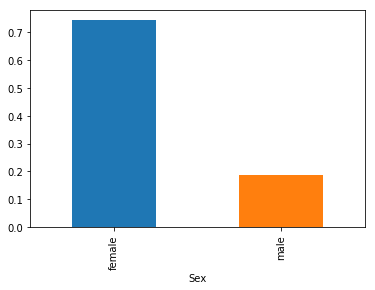

In [24]:
(a['sum'] / a['count']).plot(kind='bar')